In [15]:
import ccxt
import numpy as np
import pandas as pd
import datetime

In [16]:
PAIR_NAME = 'BTC/USDT'

In [17]:
exchange = ccxt.binance()

def fetchOHLCV(symbol: str, timeframe: str, start: str, limit: int):
	since = datetime.datetime.strptime(start, '%Y-%m-%d')
	df = exchange.fetch_ohlcv(symbol=f'{symbol}', timeframe=timeframe, since=int(datetime.datetime.timestamp(since) * 1000), limit=limit)
	df = pd.DataFrame(df, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
	df['Datetime'] = pd.to_datetime(df['Timestamp'] * 1000 * 1000, utc=True).dt.tz_convert('Asia/Hong_Kong')
	df['Change%'] = df['Close'].pct_change() * 100
	df.dropna(subset='Change%', inplace=True)
	df = df.set_index('Datetime')
	return df

df = fetchOHLCV('BTC/USDT', '1w', '2024-01-01', None)

## Charts

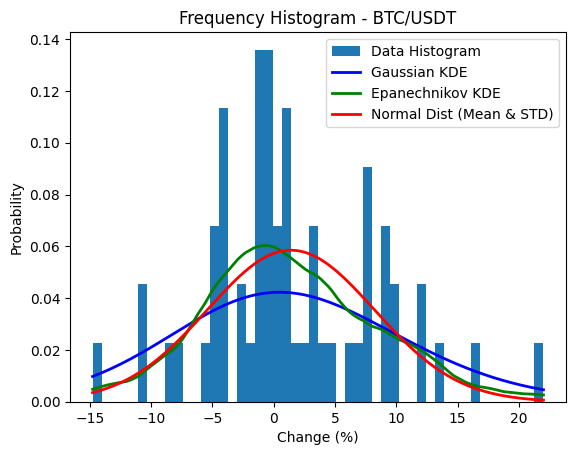

In [ ]:
# Frequency Distribution
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde, norm
from sklearn.neighbors import KernelDensity
%matplotlib inline

x_grid = np.linspace(df['Change%'].min(), df['Change%'].max(), 200)

# Normal KDE
kernel = gaussian_kde(df['Change%'], bw_method=1)
kde_values = kernel(x_grid)

# Epanechnikov KDE
kernel = KernelDensity(kernel='epanechnikov', bandwidth=1 * np.std(df['Change%'])).fit(df['Change%'].to_numpy().reshape(-1, 1))
log_kde_values2 = kernel.score_samples(x_grid.reshape(-1, 1))
kde_values2 = np.exp(log_kde_values2)

# Normal PDF
mean, std = np.mean(df['Change%']), np.std(df['Change%'])
normal_values = norm.pdf(x_grid, mean, std)

plt.hist(df['Change%'], bins=50, density=True, label='Data Histogram')
plt.plot(x_grid, kde_values, 'b-', linewidth=2, label='Gaussian KDE')
plt.plot(x_grid, kde_values2, 'g-', linewidth=2, label='Epanechnikov KDE')
plt.plot(x_grid, normal_values, 'r-', linewidth=2, label='Normal Dist (Mean & STD)')

plt.title(f'Frequency Histogram - {PAIR_NAME}')
plt.legend()
plt.ylabel('Density')
plt.xlabel('Change (%)')
plt.show()